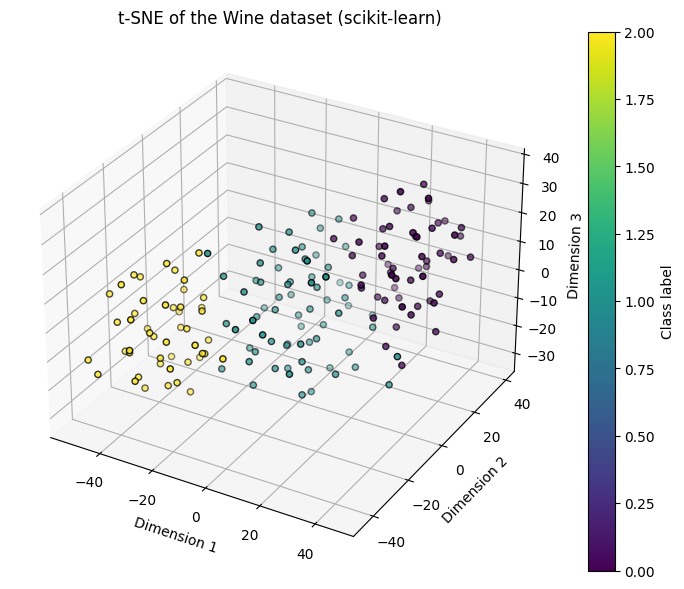

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE

# Load and prepare the Wine dataset
data = load_wine()
X = data.data
y = data.target

# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Apply t-SNE using scikit-learn
tsne = TSNE(n_components=3, perplexity=30, n_iter=1000, random_state=0)
Y = tsne.fit_transform(X)

# Plot the results
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatterplot = ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], c=y, cmap='viridis', edgecolor='k')
fig.colorbar(scatterplot, label='Class label')
ax.set_title('t-SNE of the Wine dataset (scikit-learn)')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
plt.show()


Preprocessing the data using PCA...
Computing P-values for point 0 of 178...
Mean value of sigma: 1.640651
Iteration 10: error is 11.243814
Iteration 20: error is 10.366886
Iteration 30: error is 10.978926
Iteration 40: error is 10.930667
Iteration 50: error is 10.556540
Iteration 60: error is 10.357430
Iteration 70: error is 10.612425
Iteration 80: error is 10.968565
Iteration 90: error is 11.211105
Iteration 100: error is 10.500890
Iteration 110: error is 1.385395
Iteration 120: error is 0.921018
Iteration 130: error is 0.632905
Iteration 140: error is 0.442530
Iteration 150: error is 0.335962
Iteration 160: error is 0.308964
Iteration 170: error is 0.299917
Iteration 180: error is 0.296473
Iteration 190: error is 0.294539
Iteration 200: error is 0.293011


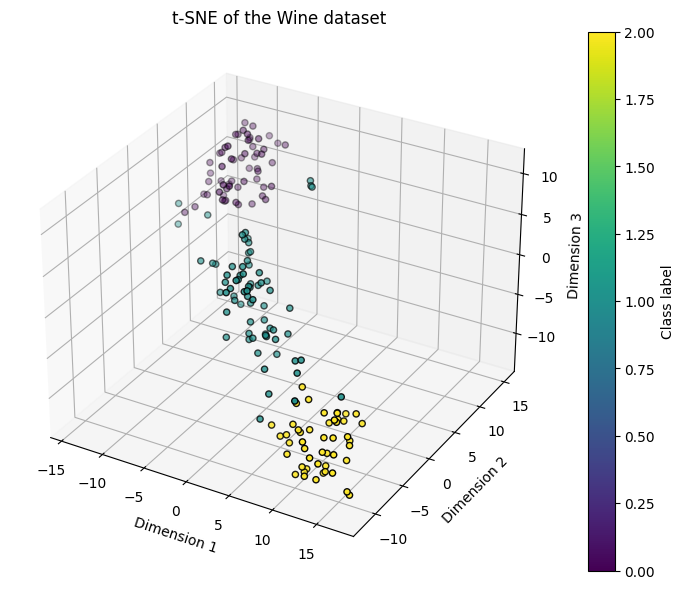

In [26]:
#### IMPLEMENTATION FROM SCRATCH ####
import numpy as np
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def Hbeta(D=np.array([]), beta=1.0):
    # P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P


def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P

def pca(X=np.array([]), no_dims=11):    ## OPTIONAL - required for data with large feature-sets.

    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:no_dims])
    return Y

def tsne(X=np.array([]), no_dims=3, initial_dims= 11, perplexity=30.0):

    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 200
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.
    P = np.maximum(P, 1e-12)

    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        if iter == 100:
            P = P / 4.

    return Y

wine = load_wine()
df=pd.DataFrame(wine['data'],columns=wine['feature_names'])

data = wine.data
target = wine.target

scalar = StandardScaler()
scaled_data = scalar.fit_transform(data)

X_embedded = tsne(scaled_data, 3, 11, 30.0)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatterplot = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], c=target, cmap='viridis', edgecolor='k')
fig.colorbar(scatterplot, label='Class label')
ax.set_title('t-SNE of the Wine dataset')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
plt.show()